# Time series - why is it important

Contrast time series problem with typical ML supervised learning problem such as regression and classification tasks. For typcial ML problems, when we make a prediction about a new observation, that model is built from hundreds or thousands of previous observations that are either all captured at a single point in time, or from data points in which time does not matter. This is known as cross-sectional data.

Time series data is different because it is recorded at regular time intervals, and the order of these data points is important. Therefore, any predictive model based on time series data will have time as an independent variable. The output of a model would be the predicted value or classification at a specific future time based on a value or values in the past. 

Here are a few examples of how different industries use time series forecasting: 

- Energy – Prices; demand; production schedules
- Retail – Sales; consumer demand for certain products
- State government – Sales tax receipts
- Transportation – Demand for future travel
- Finance – Stocks; market potential

However, this is the least talked about subject in most ML 

In [1]:
# !pip install numpy pandas pystan fbprophet plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Read in the data

Read the data in from the retail sales CSV file in the examples folder then set the index to the 'date' column. We are also parsing dates in the data file.

In [2]:
bike_share_df = pd.read_parquet('data/all_data.parquet.gzip')

# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

In [3]:
# bike_share_df.head()
# bike_share_df.rename(columns={'last_updated':'ds', 'num_bikes_available':'y'})
bike_share_df['last_updated'] = pd.to_datetime(bike_share_df['last_updated'] * 1000, unit='ms')
# bike_share_df.head(100)
bike_share_df = bike_share_df.set_index(['last_updated', 'station_id'])

bike_share_stations_df = bike_share_df.unstack()

This data is 15 minutes interval and very fine grain. Let's reduce the timescale to every hour

In [4]:
bike_share_stations_df = bike_share_stations_df.resample('1h').max()

In [5]:
bike_share_stations_df.head()

num_bikes_available                                        \
station_id                         7000  7001 7002 7003 7004  7005  7006 7007   
last_updated                                                                    
2020-10-04 20:00:00                17.0   5.0  7.0  2.0  3.0  12.0   7.0  6.0   
2020-10-04 21:00:00                17.0   7.0  5.0  1.0  4.0  12.0   9.0  5.0   
2020-10-04 22:00:00                18.0   8.0  5.0  1.0  5.0  15.0  11.0  5.0   
2020-10-04 23:00:00                20.0  10.0  5.0  3.0  5.0  16.0  11.0  5.0   
2020-10-05 00:00:00                22.0  12.0  5.0  3.0  4.0  16.0  11.0  4.0   

                                ...                                           \
station_id          7008  7009  ... 7650 7651  7653 7654 7655 7656 7657 7658   
last_updated                    ...                                            
2020-10-04 20:00:00  7.0  13.0  ...  4.0  3.0  10.0  3.0  2.0  1.0  9.0  5.0   
2020-10-04 21:00:00  7.0  14.0  ...  5.0  2.0  10.0  3.0  2.0  0.0  9.0  5.0   
2020-10-04 22:00:00  7.0  15.0  ...  5.0  2.0  10.0  3.0  2.0  0.0  9.0  5.0   
2020-10-04 23:00:00  8.0  13.0  ...  5.0  2.0   9.0  2.0  2.0  0.0  9.0  5.0   
2020-10-05 00:00:00  8.0  13.0  ...  5.0  2.0   9.0  2.0  2.0  0.0  7.0  5.0   

                               
station_id          7659 7660  
last_updated                   
2020-10-04 20:00:00  NaN  NaN  
2020-10-04 21:00:00  NaN  NaN  
2020-10-04 22:00:00  NaN  NaN  
2020-10-04 23:00:00  NaN  NaN  
2020-10-05 00:00:00  NaN  NaN  

[5 rows x 607 columns]

In [6]:
df_7030 = bike_share_stations_df['num_bikes_available']['7030'].to_frame()

In [7]:
df = bike_share_stations_df['num_bikes_available']['7030']

Let's rename the columns as required by fbprophet. Additioinally, fbprophet doesn't like the index to be a datetime...it wants to see 'ds' as a non-index column, so we won't set an index differnetly than the integer index.

In [8]:
df = df.reset_index()
df = df.rename(columns={'last_updated':'ds', '7030':'y'})

In [9]:
df.head(10)

,ds,y
0,2020-10-04 20:00:00,32.0
1,2020-10-04 21:00:00,31.0
2,2020-10-04 22:00:00,30.0
3,2020-10-04 23:00:00,32.0
4,2020-10-05 00:00:00,30.0
5,2020-10-05 01:00:00,28.0
6,2020-10-05 02:00:00,28.0
7,2020-10-05 03:00:00,44.0
8,2020-10-05 04:00:00,45.0
9,2020-10-05 05:00:00,45.0


Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

<AxesSubplot:xlabel='ds'>

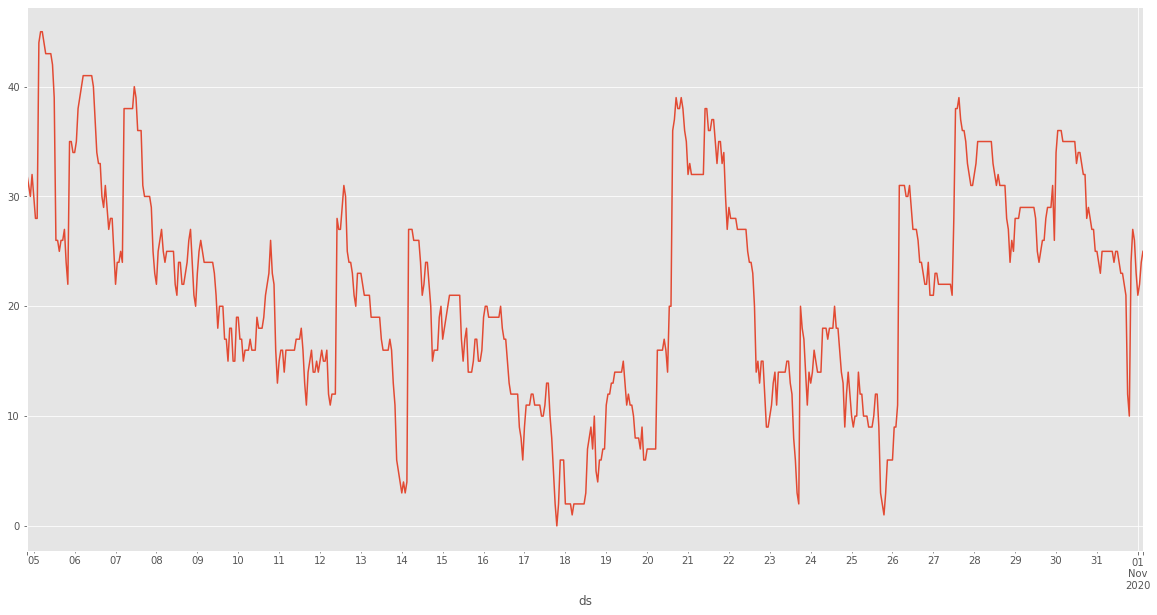

In [10]:
df.set_index('ds').y.plot()

When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. Facebook prophet's example uses the log-transform as a way to remove some of these anomolies but it isn't the absolute 'best' way to do this...but given that its the example and a simple data series, I'll follow their lead for now.  Taking the log of a number is easily reversible to be able to see your original data. 

To log-transform your data, you can use numpy's log() function

In this case, we don't see a trend but do see a daily cycle. One strategy is to apply a log transform:

    df['y'] = np.log(df['y'])

For timeseries data, this is referred to as seasonality.

# Running Prophet

Now, let's set prophet up to begin modeling our data.

Note: Since we are using monthly data, you'll see a message from Prophet saying ```Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.```  This is OK since we are workign with monthly data but you can disable it by using ```weekly_seasonality=True``` in the instantiation of Prophet.

In [11]:
model = Prophet(yearly_seasonality=False)
model.fit(df);

Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, I want to forecast 2 years into the future, so I'll built a future dataframe with 24 periods since we are working with monthly data. Note the ```freq='m'``` inclusion to ensure we are adding 24 months of data.

This can be done with the following code:


In [12]:
future = model.make_future_dataframe(periods=8, freq = 'h')
future.tail()

,ds
659,2020-11-01 07:00:00
660,2020-11-01 08:00:00
661,2020-11-01 09:00:00
662,2020-11-01 10:00:00
663,2020-11-01 11:00:00


To forecast this future data, we need to run it through Prophet's model.

In [13]:
forecast = model.predict(future)

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [14]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
659,2020-11-01 07:00:00,30.615125,16.364443,31.362606,30.615125,30.615125,-6.832064,-6.832064,-6.832064,1.685714,1.685714,1.685714,-8.517779,-8.517779,-8.517779,0.0,0.0,0.0,23.783060
660,2020-11-01 08:00:00,30.672363,16.300167,31.205251,30.672363,30.672363,-6.516604,-6.516604,-6.516604,1.857330,1.857330,1.857330,-8.373934,-8.373934,-8.373934,0.0,0.0,0.0,24.155759
661,2020-11-01 09:00:00,30.729600,17.491158,32.096840,30.729600,30.729866,-6.273093,-6.273093,-6.273093,1.927475,1.927475,1.927475,-8.200568,-8.200568,-8.200568,0.0,0.0,0.0,24.456508
662,2020-11-01 10:00:00,30.786838,16.853677,32.033501,30.785519,30.789249,-6.167501,-6.167501,-6.167501,1.831535,1.831535,1.831535,-7.999037,-7.999037,-7.999037,0.0,0.0,0.0,24.619337
663,2020-11-01 11:00:00,30.844076,16.543084,32.035033,30.840930,30.849105,-6.145964,-6.145964,-6.145964,1.624967,1.624967,1.624967,-7.770930,-7.770930,-7.770930,0.0,0.0,0.0,24.698112


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [15]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
659,2020-11-01 07:00:00,23.783060,16.364443,31.362606
660,2020-11-01 08:00:00,24.155759,16.300167,31.205251
661,2020-11-01 09:00:00,24.456508,17.491158,32.096840
662,2020-11-01 10:00:00,24.619337,16.853677,32.033501
663,2020-11-01 11:00:00,24.698112,16.543084,32.035033


# Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

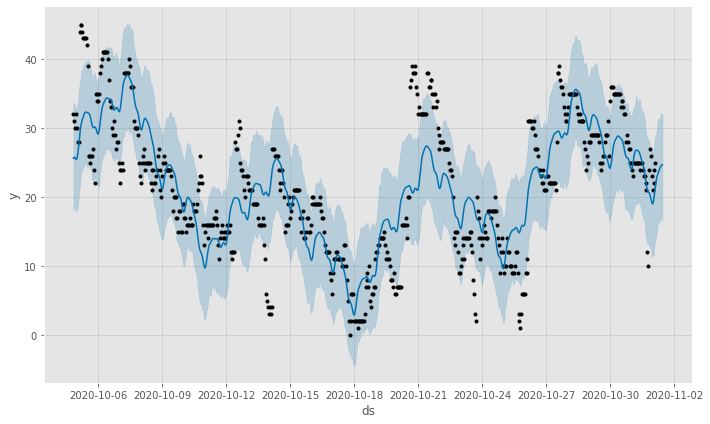

In [16]:
model.plot(forecast);

Personally, I'm not a fan of this visualization so I like to break the data up and build a chart myself.  The next section describes how I build my own visualization for Prophet modeling 

# Visualizing Prophet models

In order to build a useful dataframe to visualize our model versus our original data, we need to combine the output of the Prophet model with our original data set, then we'll build a new chart manually using pandas and matplotlib.

First, let's set our dataframes to have the same index of ```ds```

In [17]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

Now, we'll combine the original data and our forecast model data

In [18]:
viz_df = df_7030.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

If we look at the ```head()```, we see the data has been joined correctly but the scales of our original data (sales) and our model (yhat) are different. We need to rescale the yhat colums(s) to get the same scale, so we'll use numpy's ```exp``` function to do that.

In [19]:
viz_df.head()

,7030,yhat,yhat_lower,yhat_upper
2020-10-04 20:00:00,32.0,25.635666,17.937814,33.690663
2020-10-04 21:00:00,31.0,25.789660,18.686590,33.559815
2020-10-04 22:00:00,30.0,25.652281,18.513799,33.067498
2020-10-04 23:00:00,32.0,25.445605,17.868365,32.414870
2020-10-05 00:00:00,30.0,25.575340,18.119888,33.187622


Let's take a look at the ```sales``` and ```yhat_rescaled``` data together in a chart.

<AxesSubplot:>

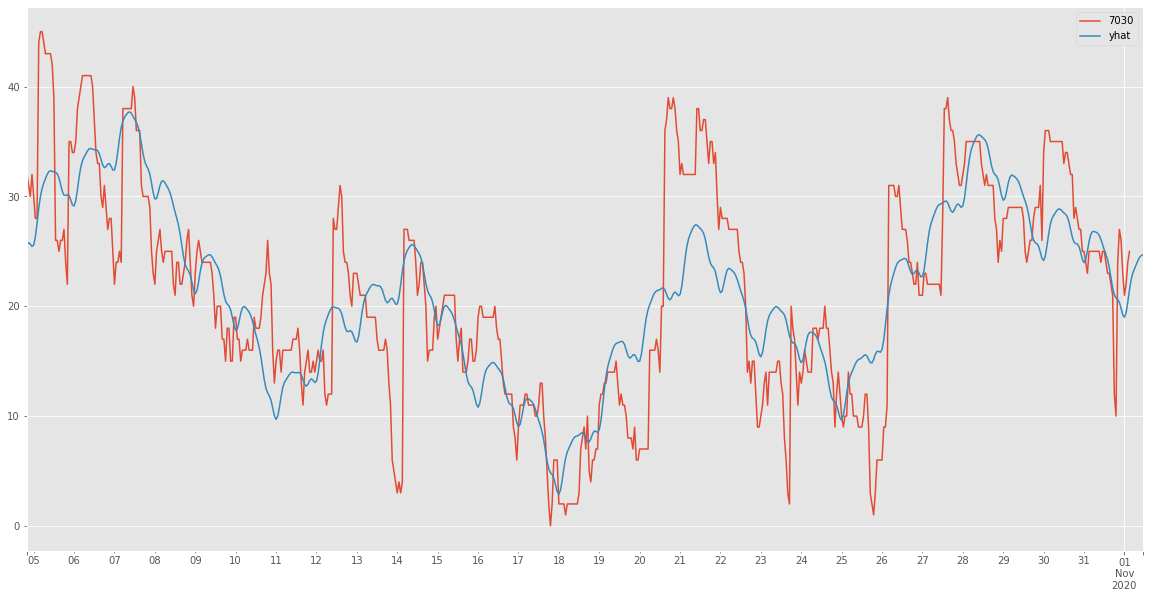

In [20]:
viz_df[['7030', 'yhat']].plot()

# Comparison with statistical model (ARIMA)
ARIMA (Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard statistical model for time series forecast and analysis.

### Import packages 
[statsmodels](https://www.statsmodels.org/stable/index.html) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. 

[sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module includes score functions, performance metrics and pairwise metrics and distance computations. 

In [21]:
#!pip install statsmodels
#!pip install sklearn
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

## ARIMA model and parameters
An ARIMA model is a class of statistical models for analyzing and forecasting time series data. ARIMA is an acronym that stands for Auto Regressive Integrated Moving Average. 

#### Key aspects of the model are:

- **AR: *Autoregression.***
 A model that uses the dependent relationship between an observation and some number of lagged observations. 

    An autoregression model makes an assumption that the observations at current and previous time steps are useful to predict the value at the next time step. We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. 
    
    The stronger the correlation between the output variable and a specified lag variable, the more weight that autoregression model can put on that variable when modeling. Because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation. 
    <br>
    
- **I: *Integrated.***
The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

    <br>
- **MA: *Moving Average.***
A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. 

    The difference between what was expected and what was predicted is called residual error. Just like the input observations, residual errors form a time series and can have temporal structure like trends, bias and seasonality. A simple and effective model of residual error is autoregression. Some number of lagged error values are used to predict the error at the next time step. The predict errors are used to correct forecasts. 
    > *improved forecast = forecast + estimated error*
    
    An autoregression of the residual error time series is called a Moving Average (MA) model. It has nothing to do with the moving average smoothing process.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

#### The parameters of the ARIMA model are defined as follows:

- **p**: The number of lag observations included in the model, also called the lag order.
- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
- **q**: The size of the moving average window, also called the order of moving average.

## Step 1 - Grid Search 
Grid search is the process of training and evaluating models on different combinations of model hyperparameters. In machine learning, a hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are derived via training.

ARIMA model for time series forecasting can be tricky to configure. We will evaluate ARIMA model using different combinations of (p, d, q) and find the one with the best score i.e. minimum mean squared error on the validation set.

In [51]:
# Hourly data points
arima_validation_set_size = 7
arima_test_set_size = 8
arima_dataset = df_7030["7030"]
arima_dataset.head()

last_updated
2020-10-04 20:00:00    32.0
2020-10-04 21:00:00    31.0
2020-10-04 22:00:00    30.0
2020-10-04 23:00:00    32.0
2020-10-05 00:00:00    30.0
Freq: H, Name: 7030, dtype: float64

#### Helper function to evaluate arima model

In [37]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train, validation = X[1:len(X) - arima_validation_set_size], X[len(X)-arima_validation_set_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(validation)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(validation[t])
    # calculate out-of-sample error
    rmse = sqrt(mean_squared_error(validation, predictions))
    return rmse

#### Helper function to interate over different combinations of parameters and evaluate ARIMA model

In [38]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

#### Evaluate ARIMA model with different combinations of p, d, and q values

In [35]:
p_values = [0, 1, 2, 4, 6, 8, 10, 12]
d_values = range(0 ,3)
q_values = range(0, 3)

warnings.filterwarnings("ignore")

evaluate_models(arima_dataset, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=3.369
ARIMA(0, 0, 1) RMSE=2.013
ARIMA(0, 0, 2) RMSE=3.192
ARIMA(0, 1, 0) RMSE=2.035
ARIMA(0, 1, 1) RMSE=1.815
ARIMA(0, 1, 2) RMSE=1.765
ARIMA(0, 2, 0) RMSE=4.675
ARIMA(0, 2, 1) RMSE=2.038
ARIMA(0, 2, 2) RMSE=1.812
ARIMA(1, 0, 0) RMSE=2.008
ARIMA(1, 0, 1) RMSE=1.714
ARIMA(1, 0, 2) RMSE=1.702
ARIMA(1, 1, 0) RMSE=1.841
ARIMA(1, 1, 1) RMSE=1.812
ARIMA(1, 1, 2) RMSE=1.694
ARIMA(1, 2, 0) RMSE=4.265
ARIMA(1, 2, 1) RMSE=1.838
ARIMA(1, 2, 2) RMSE=1.909
ARIMA(2, 0, 0) RMSE=1.738
ARIMA(2, 0, 1) RMSE=1.711
ARIMA(2, 0, 2) RMSE=1.645
ARIMA(2, 1, 0) RMSE=1.723
ARIMA(2, 1, 1) RMSE=1.717
ARIMA(2, 1, 2) RMSE=1.624
ARIMA(2, 2, 0) RMSE=4.012
ARIMA(2, 2, 1) RMSE=1.723
ARIMA(2, 2, 2) RMSE=1.854
ARIMA(4, 0, 0) RMSE=1.571
ARIMA(4, 0, 1) RMSE=1.567
ARIMA(4, 0, 2) RMSE=1.769
ARIMA(4, 1, 0) RMSE=1.486
ARIMA(4, 1, 1) RMSE=1.506
ARIMA(4, 1, 2) RMSE=1.681
ARIMA(4, 2, 0) RMSE=2.241
ARIMA(4, 2, 1) RMSE=1.496
ARIMA(4, 2, 2) RMSE=1.473
ARIMA(6, 0, 0) RMSE=1.477
ARIMA(6, 0, 1) RMSE=1.551
ARIMA(6, 0, 

## Step 2 - Predictions using best ARIMA model
Using the best paramters for ARIMA, predict for the next 8 hours.

In [54]:
X = arima_dataset
train, test = X[1:len(X) - arima_test_set_size], X[len(X)-arima_test_set_size:]
history = [x for x in train]
predictions = list()
p = 10
d = 2
q = 2

for t in range(len(test)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.6f' % rmse)

predicted=10.207323, expected=24.000000
predicted=25.459977, expected=27.000000
predicted=26.986497, expected=26.000000
predicted=25.421011, expected=23.000000
predicted=22.469991, expected=21.000000
predicted=21.445947, expected=22.000000
predicted=23.355961, expected=24.000000
predicted=25.210145, expected=25.000000
Test RMSE: 5.029549


## Step 3 - Plot
TODO Plot with Prophet predictions

<AxesSubplot:xlabel='last_updated'>

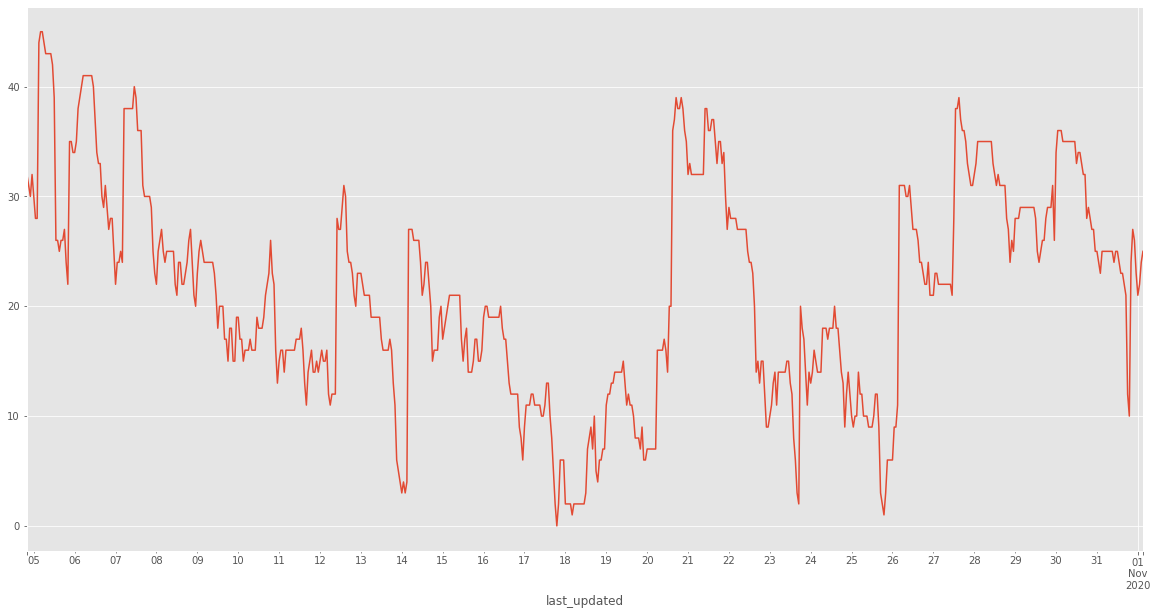

In [55]:
arima_dataset.plot()

## References
- [Introduction to Time Series Forecasting with Python - Jason Brownlee](https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/)